# Loopcheck Fault Countermeasure

In this notebook, we present a detection-based fault countermeasure called loopcheck which is used to protect high-level control-flow constructs such as loops. If fault injection occurs during the execution of a for loop running repititive steps such that it bypasses few iterations to get the intermediate value or bypass some later checks. Suppose, this happens during the execution of AES algorithm iterating over the number of rounds and attacker is able to inject faults such that AES runs for just one round and finishes, this would weaken the security of the algorithm and reveal the secret key to the attacker. If fault gets detected timely, it is possible to prevent such fault violations. 
<br> In following sections, we learn about loopcheck countermeasure through a simple example C code. 

## FIA simulation on original code

We perform fault injection experiment uisng the FIA simulation framework discussed in **Getting Started.ipynb** on the program whose C code and its corresponding assembly code is shown below.
<img src="../img/c_dis_test2.jpg" width =1000 height=1000 />


We can see that the expected output of the program on fault-free execution will be `Value of y = 20`. We can also run the program directly on TSIM-LEON3 to verify the expected output. 

We inject faults when the highlighted instruction shown in assembly code executes and as a result it leads to the skipping of single next instruction. Skipping of **bl** branch instruction will bypass the for loop altogether. This will simulate the instance if fault attack occurs while the **program counter** gets incremented to point to next instruction and fault modifies the **program counter** to skip next instruction.

We configure fault injection parameters in **param_dict** such that we inject single fault to do a single instruction skip. As our target instruction to inject fault is at **0x4000128c** address, we set start address as **0x40001288** and end address as **0x4000128c**. This fault injection attack selects a instruction skip fault model. 
<br> Here is how we do fault injection on original code: 

In [2]:
%%capture output --no-stdout


import papermill as pm
from IPython import display
import os


abs_path = os.path.abspath("../")
test_path = abs_path + '/src/loopcheck_cm/elf/test2.elf'
in_nb = abs_path + '/software/fia_framework/InputNotebook.ipynb'
out_nb = abs_path + '/software/fia_framework/OutputNotebook.ipynb'

# Random Register Corruption Fault Model
param_dict = dict(fault_count=1, bit_flips=0, consecutive_flips=1, skips=1, instr_modify=0, iterations=1, \
data=0, verbose=True, binary=test_path, correct_output='Value of y = 20', byte=False, \
start=0x40001288, end=0x4000128c)


pm.execute_notebook(in_nb, out_nb, parameters = param_dict, log_output = True)

We get the output logs and plot for classication of output from FIA simulation framework by running following code:

0x4000128c cmp %g2, %g1

0x40001290 bl (skipped +0)
pc: 0x40001290 -> 0x40001294

output is incorrect (Value of y = 0)





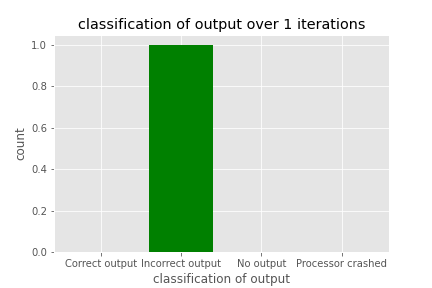

In [3]:
#print output

var = output.stderr
print(var)

display.Image("./output_plot.png")

We observe that the value of variable *y* is zero since for loop is bypassed due to **bl instruction skip**.

## FIA simulation on hardened code

To secure the control-flow integrity of for loop, we perform loop hardening by verifying correct termination of the loop. 
<br> We verify the loop condition variable by adding following line to the original code:
<br> `if(i != n) <br>
		printf("{Fault Detected}");`

This check condition will detect the instrcution skip faults.

<img src="../img/c_dis_test2_loopcheck.jpg" width =1000 height=1000 />


This time we run the fault injection experiment on hardened code attacking the same target instruction with same fault injection parameters except the **correct_output** parameter which changes to `Fault Detected`.  

In [4]:
%%capture output --no-stdout

import papermill as pm
from IPython import display
import os

abs_path = os.path.abspath("../")
test_path = abs_path + '/src/loopcheck_cm/elf/test2_loopcheck.elf'
in_nb = abs_path + '/software/fia_framework/InputNotebook.ipynb'
out_nb = abs_path + '/software/fia_framework/OutputNotebook.ipynb'

# Random Register Corruption Fault Model
param_dict = dict(fault_count=1, bit_flips=0, consecutive_flips=1, skips=1, instr_modify=0, iterations=1, \
data=0, verbose=True, binary=test_path, correct_output='Fault Detected', byte=False, \
start=0x40001288, end=0x4000128c)


pm.execute_notebook(in_nb, out_nb, parameters = param_dict, log_output = True)

We get the output logs and plot for classication of output from FIA simulation framework by running following code:

0x4000128c cmp %g2, %g1

0x40001290 bl (skipped +0)
pc: 0x40001290 -> 0x40001294

output is correct (Fault Detected)





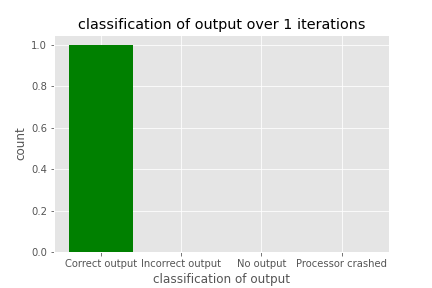

In [5]:
#print output

var = output.stderr
print(var)

display.Image("./output_plot.png")

We observe that the target application when protected with loopcheck countermeasure is able to detect the single **bl** instruction skip fault. We can further stregthen the loop verify condition by adding double checks for it in case **bl** corresponding to loop verify condition gets skipped due to another single instruction skip fault. Double check protection for loop verify condition is given as follows:

`if(c = i != n) {` <br>
`if(!c)`<br>
         `print("{Fault Detected}");` <br>
`} else {` <br>
`if(c)` <br>
         `print("{Fault Detected}");` <br>
`}`

## References

1. M. Witteman, "Secure Application Programming in the presence of Side Channel Attacks"